# Evaluation of Data Integration

In this notebook, we evaluate how effective two relations can be integrated using the soft join operator.
Therefore, we utilize the [Datasets for DeepMatcher paper](https://github.com/anhaidgroup/deepmatcher/blob/master/Datasets.md).

The datasets contain two relations with the same entities from two different sources.
E.g. `iTunes-Amazon` contains song records obtained from iTunes and Amazon. So, the task is to identify same songs.

To test different Models, datasets, ..., there are parameters in the [modifications](#modifications) section.
**Modfy Code in [Modifications](#modifications) Section Only!**

We calculate:
* $ TP = \text{True Matches} \cap \text{Predicted Matches} $
* $ FN = \text{True Matches} \setminus \text{Predicted Matches} $
* $ FP = \text{Predicted Matches} \setminus \text{True Matches} $

To determine the scores:
* $ Precision = \frac{TP}{TP + FP}$
* $ Recall = \frac{TP}{TP + FN}$
* $ F_1 = \frac{2 \cdot precision \cdot recall}{precision + recall} $
* BLEU 1-4

## Imports

In [19]:
import time
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from db.operators import Dummy, InnerSoftJoin

from models import ModelMgr
from models.embedding.SentenceTransformer import SentenceTransformerEmbeddingModel
from models.semantic_validation import LLaMAValidationModel

from evaluation.util import calculate_metrics

In [2]:
with open("DataIntegration.json") as f:
    datasets = json.load(f)

## Modifications

In [3]:
dataset_name = "iTunesAmazon" # The tested dataset

significant_columns_left = ["Album_Name", "Artist_Name", "Released", "Song_Name", "Time"]
significant_columns_right = ["Album_Name", "Artist_Name", "Released", "Song_Name", "Time"]

## Function and Dataset Declarations

In [4]:
significant_columns_left = [f"left_{x}" for x in significant_columns_left]
significant_columns_right = [f"right_{x}" for x in significant_columns_right]

In [5]:
dataset = datasets[dataset_name]
matches = pd.DataFrame(dataset["matches"])
matches.head(2)

,snoLeft,snoRight
0,111,53124
1,148,50767


In [6]:
left = pd.DataFrame(dataset["left"])
left.rename(columns={c: f"left_{c}" for c in left.columns}, inplace=True)
left.head(2)

,left_snoLeft,left_Album_Name,left_Album_Price,left_Artist_Name,left_CopyRight,left_Customer_Rating,left_Genre,left_Price,left_Released,left_Song_Name,left_Time
0,111,VHS,$7.99,X Ambassadors,2015 KIDinaKORNER/Interscope Records,4.54839,"Alternative,Music,Rock,Adult Alternative",$1.29,30-Jun-15,VHS Outro (Interlude),1:25
1,148,Title (Deluxe),$12.99,Meghan Trainor,"2014, 2015 Epic Records, a division of Sony M...",4.06740,"Pop,Music,Rock,Pop/Rock,Dance,Teen Pop",$1.29,9-Jan-15,Credit,2:51


In [7]:
right = pd.DataFrame(dataset["right"])
right.rename(columns={c: f"right_{c}" for c in right.columns}, inplace=True)
right.head(2)

,right_snoRight,right_Album_Name,right_Artist_Name,right_Song_Name,right_Price,right_Time,right_Released,right_Label,right_Copyright,right_Genre
0,363,#NAME?,Ed Sheeran,Sunburn (Deluxe Edition),$1.29,4:35,"September 9, 2011",Atlantic Records UK,Doll records,Pop
1,379,#NAME?,Ed Sheeran,Sunburn (Deluxe Edition),$1.29,4:35,"September 9, 2011",Atlantic Records UK,Doll records,Pop


In [8]:
candidates = matches\
    .merge(left, left_on=matches.columns[0], right_on=f"left_{matches.columns[0]}")\
    .merge(right, left_on=matches.columns[1], right_on=f"right_{matches.columns[1]}")\
    .drop(columns=matches.columns)

candidates.head(2)

,left_snoLeft,left_Album_Name,left_Album_Price,left_Artist_Name,left_CopyRight,left_Customer_Rating,left_Genre,left_Price,left_Released,left_Song_Name,...,right_snoRight,right_Album_Name,right_Artist_Name,right_Song_Name,right_Price,right_Time,right_Released,right_Label,right_Copyright,right_Genre
0,111,VHS,$7.99,X Ambassadors,2015 KIDinaKORNER/Interscope Records,4.54839,"Alternative,Music,Rock,Adult Alternative",$1.29,30-Jun-15,VHS Outro (Interlude),...,53124,VHS [Explicit],X Ambassadors,VHS Outro (Interlude) [Explicit],$1.29,1:25,"June 30, 2015",KIDinaKORNER/Interscope Records,(C) 2015 KIDinaKORNER/Interscope Records,Alternative Rock
1,148,Title (Deluxe),$12.99,Meghan Trainor,"2014, 2015 Epic Records, a division of Sony M...",4.06740,"Pop,Music,Rock,Pop/Rock,Dance,Teen Pop",$1.29,9-Jan-15,Credit,...,50767,Title (Deluxe),Meghan Trainor,Credit,$1.29,2:51,"January 9, 2015",Epic,"2011 What A Music Ltd, licence exclusive Parl...",Pop


In [9]:
gt = {tuple([x[col] for col in list(left.columns) + list(right.columns)]) for _, x in candidates.iterrows()}
print(str(gt)[0:500] + "...")

{(3355, 'Flight School', '$9.99 ', 'Wiz Khalifa', ' 2009 Rostrum Records', 4.47268, 'Hip-Hop/Rap,Music', '$0.99 ', '17-Apr-09', 'Extra Extra Credit', '4:03', 17655, 'Flight School [Explicit]', 'Wiz Khalifa', 'Extra Extra Credit [Explicit]', '$0.99', '4:03', ' April 17, 2009', ' Rostrum Records', ' 2013 Mad Decent', 'Rap & Hip-Hop'), (2223, '1989', '$9.99 ', 'Ryan Adams', ' 2015 PaxAmericana Recording Company Under Exclusive License To Blue Note Records', 3.53792, 'Rock,Music', '$1.29 ', '21-Sep-...


## Evaluation
### Execute Operator and Evaluate

In [15]:
def evaluate(em, sv, threshold, method, embedding_comparison, embedding_method, calc_bleu=False):
    key = (threshold, method, embedding_comparison, embedding_method)

    op1 = Dummy("ltable", left.columns, list(left.values))
    op2 = Dummy("rtable", right.columns, list(right.values))

    op = InnerSoftJoin(
        op1, op2, em=em, sv=sv,
        threshold=threshold, method=method,
        columns_left=significant_columns_left, columns_right=significant_columns_right,
        embedding_comparison=embedding_comparison,
        embedding_method = embedding_method
    )

    tic = time.time()
    result = op.open().fetch_all()
    toc = time.time()
    pred = {tuple([x[col] for col in list(left.columns) + list(right.columns)]) for x in result}

    scores = calculate_metrics(gt, pred, toc - tic)

    print(key, scores["Precision"], scores["Recall"], scores["F1 Score"])

    return key, scores

In [12]:
# Models
m = ModelMgr()
stem = SentenceTransformerEmbeddingModel(m)
lsv = LLaMAValidationModel(m)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
threshold_experiments_data = []

for t in np.linspace(1.0, 0.5, 100):
    res = evaluate(stem, lsv, threshold = t, method = "threshold", embedding_comparison = "COLUMN_WISE", embedding_method = None)
    threshold_experiments_data.append((t, res[1]))

(1.0, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9949494949494949, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.98989898989899, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9848484848484849, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9797979797979798, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9747474747474747, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9696969696969697, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9646464646464646, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9595959595959596, 'threshold', 'COLUMN_WISE', None) 0 0.0 0
(0.9545454545454546, 'threshold', 'COLUMN_WISE', None) 1.0 0.007575757575757576 0.015037593984962407
(0.9494949494949495, 'threshold', 'COLUMN_WISE', None) 1.0 0.015151515151515152 0.02985074626865672
(0.9444444444444444, 'threshold', 'COLUMN_WISE', None) 1.0 0.03787878787878788 0.07299270072992702
(0.9393939393939394, 'threshold', 'COLUMN_WISE', None) 1.0 0.10606060606060606 0.19178082191780824
(0.9343434343434344, 'threshold', 'COLUMN_WISE', No

0.7373737373737373 0.9191919191919192 0.9595959595959596


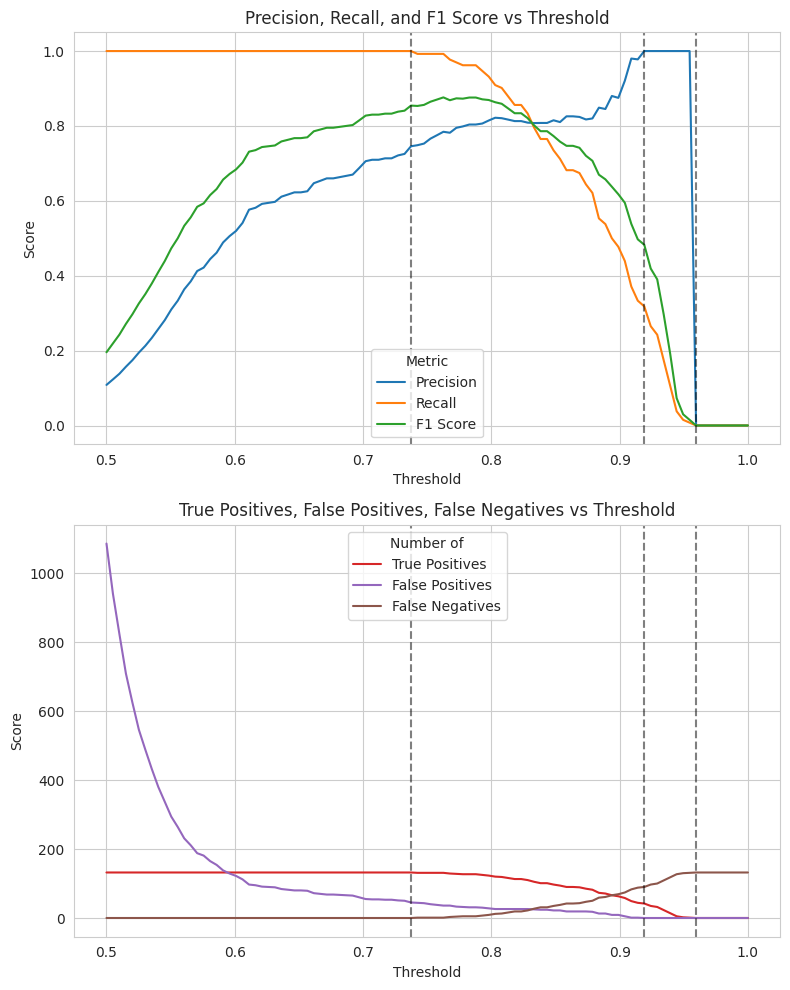

In [46]:
df = pd.DataFrame(threshold_experiments_data, columns=["threshold", "data"])

df["Precision"] = df.data.apply(lambda x: x["Precision"])
df["Recall"] = df.data.apply(lambda x: x["Recall"])
df["F1 Score"] = df.data.apply(lambda x: x["F1 Score"])
df["tp"] = df.data.apply(lambda x: x["tp"])
df["fp"] = df.data.apply(lambda x: x["fp"])
df["fn"] = df.data.apply(lambda x: x["fn"])

df_melt1 = pd.melt(df, id_vars=['threshold'], value_vars=['Precision', 'Recall', "F1 Score"], var_name="Metric")
df_melt2 = pd.melt(df, id_vars=['threshold'], value_vars=['tp', 'fp', 'fn'], var_name="Number of").replace({'tp': 'True Positives', 'fp': 'False Positives', 'fn': 'False Negatives'})

tps = df_melt2[df_melt2["Number of"] == "True Positives"]
max_tps = tps[tps["value"] == max(tps["value"])]
max_threshold_tps = max_tps[max_tps["threshold"] == max(max_tps.threshold)].values[0][0]

tps = df_melt2[df_melt2["Number of"] == "True Positives"]
min_tps = tps[tps["value"] == min(tps["value"])]
min_threshold_tps = min_tps[min_tps["threshold"] == min(min_tps.threshold)].values[0][0]

tps = df_melt2[df_melt2["Number of"] == "False Positives"]
min_fps = tps[tps["value"] == min(tps["value"])]
min_threshold_fps = min_fps[min_fps["threshold"] == min(min_fps.threshold)].values[0][0]

print(max_threshold_tps, min_threshold_fps, min_threshold_tps)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

palette = sns.color_palette("tab10", n_colors=6)
palette1, palette2 = palette[:3], palette[3:]

sns.lineplot(data=df_melt1, x="threshold", y="value", hue="Metric", ax=ax1, palette=palette1)
sns.lineplot(data=df_melt2, x="threshold", y="value", hue="Number of", ax=ax2, palette=palette2)

color_indication_line = "black"

# Labels and title
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.set_title("Precision, Recall, and F1 Score vs Threshold")
ax1.axvline(max_threshold_tps, c = color_indication_line, alpha = 0.5, linestyle="--")
ax1.axvline(min_threshold_fps, c = color_indication_line, alpha = 0.5, linestyle="--")
ax1.axvline(min_threshold_tps, c = color_indication_line, alpha = 0.5, linestyle="--")

ax2.set_xlabel("Threshold")
ax2.set_ylabel("Score")
ax2.set_title("True Positives, False Positives, False Negatives vs Threshold")
ax2.axvline(max_threshold_tps, c = color_indication_line, alpha = 0.5, linestyle="--")
ax2.axvline(min_threshold_fps, c = color_indication_line, alpha = 0.5, linestyle="--")
ax2.axvline(min_threshold_tps, c = color_indication_line, alpha = 0.5, linestyle="--")
# Show plot
fig.tight_layout()
plt.savefig("results/img/pcf_vs_threshold.pdf")
plt.show()